# Index Tracking with Gurobi

This Python notebook is part of the webinar [Proven Techniques for Solving Financial Problems with Gurobi](https://www.gurobi.com/events/proven-techniques-for-solving-financial-problems-with-gurobi/).

The sequence of python code will:
1. Import stock data from yahoo finance
2. Clean up the data and change format
3. Perform an index tracking experiment

## Importing Data from YFinance

- Adjusted Stock price data for SP100 constitutents 
- Data from 2010 to 2022

In [1]:
print("oi")

oi


In [2]:
from utils.data_import import get_sp100, get_ibv

# Options
FIRST_DATE  = "2020-01-01"
LAST_DATE   = "2025-01-01"

df_prices_sp = get_sp100(FIRST_DATE,LAST_DATE)

df_prices_sp.head()

Fetching SP100 components
	-> got 101 tickers



c:\Users\joaov\Documents\bootcamp-ds-4ed\utils\data_import.py:50: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=FIRST_DATE, end=LAST_DATE)["Close"]
[*********************100%***********************]  102 of 102 completed

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM,^SP100
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,72.468254,69.823471,78.208031,192.514999,334.429993,44.517937,49.099998,199.607407,195.522324,94.900497,...,267.026398,160.492828,91.948654,46.150040,183.186218,43.349491,46.052395,36.508095,53.661709,1458.130005
2020-01-03,71.763733,69.160706,77.254616,192.194412,331.809998,44.173904,48.599998,198.252304,195.616455,93.748497,...,264.324188,159.356964,91.893532,45.612144,181.729355,42.887951,45.769657,36.185806,53.230305,1446.479980
2020-01-06,72.335571,69.706490,77.659363,190.939331,333.709991,44.208313,48.389999,199.773712,195.565079,95.143997,...,266.159119,157.992172,91.484123,44.988503,181.336319,42.795650,45.495480,36.112137,53.639015,1452.810059
2020-01-07,71.995354,69.308853,77.227615,186.816986,333.390015,43.958878,48.250000,197.894852,191.397980,95.343002,...,264.552460,156.794617,91.326668,44.559734,180.857101,42.319893,45.118500,35.777565,53.200027,1447.359985
2020-01-08,73.153496,69.800064,77.542435,187.183441,337.869995,44.474934,47.830002,198.044479,193.057983,94.598503,...,270.130249,158.511658,91.846298,44.466187,183.953033,42.397999,45.255581,35.654793,52.397751,1455.489990


In [3]:
df_prices_ibv = get_ibv(FIRST_DATE,LAST_DATE)

df_prices_ibv.head()

Fetching IBOV components
	-> got 88 tickers



c:\Users\joaov\Documents\bootcamp-ds-4ed\utils\data_import.py:102: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=FIRST_DATE, end=LAST_DATE)["Close"]
[*********************100%***********************]  89 of 89 completed

17 Failed downloads:
['CCRO3.SA', 'NTCO3.SA', 'LCAM3.SA', 'BIDI11.SA', 'CRFB3.SA', 'JBSS3.SA', 'CIEL3.SA', 'MRFG3.SA', 'SOMA3.SA', 'ENBR3.SA', 'BRFS3.SA', 'SULA11.SA', 'VIIA3.SA', 'GOLL4.SA', 'BRML3.SA']: YFTzMissingError('possibly delisted; no timezone found')
['HAPV3.SA']: Timeout('Failed to perform, curl: (28) Connection timed out after 10010 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['VALE3.SA']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Ticker,ABEV3.SA,ALPA4.SA,AMER3.SA,ASAI3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,...,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA,^BVSP
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,14.743884,28.379305,6333.258789,NaN,58.799999,12.181201,17.415005,18.467068,19.764900,22.437403,...,21.407814,9.829419,7.763107,NaN,19.840027,NaN,16.607275,16.119911,41.797306,118573.0
2020-01-03,14.536547,28.379305,6247.752441,NaN,56.759998,11.830161,17.385876,18.178900,19.774900,22.190065,...,21.862907,9.714233,7.683076,NaN,19.723854,NaN,16.800064,15.914062,40.921127,117707.0
2020-01-06,14.605659,27.935064,6208.886719,NaN,55.000000,11.716745,17.156042,18.074633,19.421690,22.555193,...,21.364471,9.503054,7.539018,NaN,18.736368,NaN,16.638262,15.955231,41.707901,116878.0
2020-01-07,14.636373,28.570938,6193.339844,NaN,56.820000,12.094792,17.026562,17.767050,19.084282,22.566965,...,21.454256,9.714233,7.611047,NaN,18.710552,NaN,17.006626,16.078745,40.930061,116662.0
2020-01-08,14.567263,28.884523,6275.930664,NaN,56.919998,12.062388,16.871183,17.495956,18.789064,22.555193,...,21.166340,9.637439,7.515008,NaN,18.620192,NaN,17.178757,15.470352,40.688667,116247.0


## Cleaning and Splitting the Data

In [4]:
from utils.data_clean import clean_data

THRESH_VALID_DATA = 0.95 # defines where to cut stocks with missing data
PERC_SIZE_TRAIN = 0.80   # defines the size of train dataset (in %)

df_ret_sp, df_train_sp, df_test_sp  = clean_data(
    df_prices_sp, 
    thresh_valid_data = THRESH_VALID_DATA,
    size_train = PERC_SIZE_TRAIN
)

df_ret_ibv, df_train_ibv, df_test_ibv  = clean_data(
    df_prices_ibv, 
    thresh_valid_data = THRESH_VALID_DATA,
    size_train = PERC_SIZE_TRAIN
)

print("Data Cleaned")
print("Training and testing data separated")

Data Cleaned
Training and testing data separated


In [5]:
from utils.data_process import find_weights

quarters_data_sp = find_weights(df_test_sp)

for q, df_part in quarters_data_sp.items():
    print(f"{q}: {len(df_part)} observações, de {df_part.index.min().date()} a {df_part.index.max().date()}")

Q1: 62 observações, de 2024-01-02 a 2024-04-01
Q2: 63 observações, de 2024-04-02 a 2024-07-01
Q3: 63 observações, de 2024-07-02 a 2024-09-30
Q4: 64 observações, de 2024-10-01 a 2024-12-31


In [6]:
quarters_data_ibv = find_weights(df_test_ibv)

for q, df_part in quarters_data_ibv.items():
    print(f"{q}: {len(df_part)} observações, de {df_part.index.min().date()} a {df_part.index.max().date()}")

Q1: 62 observações, de 2024-01-04 a 2024-04-03
Q2: 62 observações, de 2024-04-04 a 2024-07-02
Q3: 64 observações, de 2024-07-03 a 2024-09-30
Q4: 61 observações, de 2024-10-01 a 2024-12-30


## Constrained Index Tracking

$
\begin{array}{llll}
  & \min              & \frac{1}{T} \; \sum_{t = 1}^{T} \left(\sum_{i = 1}^{I} \; w_{i} \: \times \: r_{i,t} - R_{t}\right)^2 \\
  & \text{subject to} &   \sum_{i = 1}^{I} w_{i}  = 1  \\
  &                   &   \sum_{i = 1}^{I} z_{i} \leq K \\
  &                   & w_i \geq 0 \\
  &                   & z_i \in {0, 1}
\end{array}
$

  

$
\begin{array}{lllll}
& where: \\
& \\
& w_i  &: \text{Weight of asset i in index} \\
& z_i &: \text{Binary variable (0, 1) that decides wheter asset i is in portfolio} \\
& R_{t} &: \text{Returns of tracked index (e.g. SP500) at time t} \\
& r_{i,j} &: \text{Return of asset i at time t}
\end{array}
$

In [ ]:
# bons valores para testar
# escolher valores iguais a 3 ou maiores

# max_assets = 3  
# time = 2

# max_assets = 10  
# time = 5

In [7]:
from utils.data_process import index_tracking

# Ajuste os parametros abaixo para testar diferentes
# quantidades de ações e de tempo para otimizar
# o 'i' é apenas para printar qual trimestre estamos otimizando
max_assets = 10 # escolher valores iguais a 3 ou maiores
time = 10

portfolio_cumret_sp, market_cumret_sp = index_tracking(quarters_data_sp, "^SP100",max_assets, df_train_sp, df_test_sp, time)

Restricted license - for non-production use only - expires 2027-11-29
Starting the optimization process for the 1 trimester 
It will take 10 seconds to it's conclusion
✅ 10 ações selecionadas:
   JNJ: 15.23%
   AAPL: 13.25%
   JPM: 11.61%
   MSFT: 11.10%
   GD: 10.58%
   AMZN: 9.29%
   GOOGL: 8.05%
   V: 7.97%
   HD: 7.71%
   NVDA: 5.21%
Starting the optimization process for the 2 trimester 
It will take 10 seconds to it's conclusion
✅ 10 ações selecionadas:
   AAPL: 13.49%
   JNJ: 13.03%
   MSFT: 12.93%
   JPM: 11.87%
   KO: 11.75%
   AMZN: 8.44%
   GOOGL: 8.11%
   HD: 7.96%
   NVDA: 6.34%
   XOM: 6.08%
Starting the optimization process for the 3 trimester 
It will take 10 seconds to it's conclusion
✅ 10 ações selecionadas:
   JPM: 13.55%
   AAPL: 13.26%
   JNJ: 11.80%
   MSFT: 11.13%
   GD: 10.69%
   PG: 10.03%
   AMZN: 8.95%
   GOOG: 8.81%
   AVGO: 6.43%
   NVDA: 5.35%
Starting the optimization process for the 4 trimester 
It will take 10 seconds to it's conclusion
✅ 10 ações seleci

In [9]:
portfolio_cumret_ibv, market_cumret_ibv = index_tracking(quarters_data_ibv, "^BVSP",max_assets, df_train_ibv, df_test_ibv, time)

Starting the optimization process for the 1 trimester 
It will take 10 seconds to it's conclusion
✅ 10 ações selecionadas:
   BRAP4.SA: 15.39%
   BBDC3.SA: 12.87%
   PETR4.SA: 12.74%
   EQTL3.SA: 10.82%
   ABEV3.SA: 10.80%
   BBAS3.SA: 8.79%
   B3SA3.SA: 8.45%
   RENT3.SA: 8.18%
   KLBN11.SA: 8.04%
   MGLU3.SA: 3.91%
Starting the optimization process for the 2 trimester 
It will take 10 seconds to it's conclusion
✅ 10 ações selecionadas:
   BRAP4.SA: 15.44%
   PETR4.SA: 14.03%
   ITSA4.SA: 13.34%
   BBDC3.SA: 10.94%
   ABEV3.SA: 9.36%
   ENGI11.SA: 8.80%
   RENT3.SA: 8.57%
   B3SA3.SA: 8.57%
   KLBN11.SA: 6.99%
   MGLU3.SA: 3.96%
Starting the optimization process for the 3 trimester 
It will take 10 seconds to it's conclusion
✅ 10 ações selecionadas:
   BRAP4.SA: 15.30%
   ITSA4.SA: 14.43%
   PETR4.SA: 14.32%
   BBDC3.SA: 10.21%
   ABEV3.SA: 9.09%
   ENGI11.SA: 8.97%
   B3SA3.SA: 8.70%
   RENT3.SA: 8.01%
   KLBN11.SA: 7.12%
   MGLU3.SA: 3.84%
Starting the optimization process for the 4

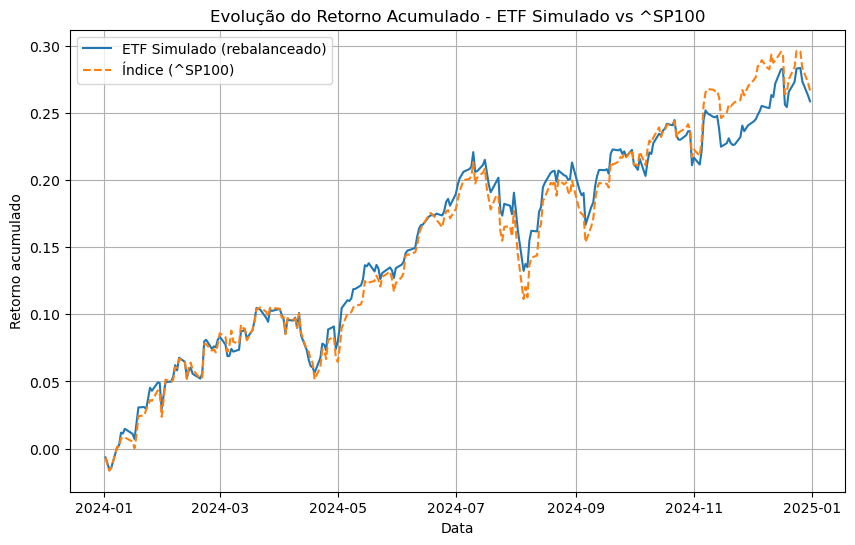

In [8]:
# --- Plot comparativo ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(portfolio_cumret_sp.index, portfolio_cumret_sp, label='ETF Simulado (rebalanceado)')
plt.plot(market_cumret_sp.index, market_cumret_sp, label='Índice (^SP100)', linestyle='--')
plt.title(f"Evolução do Retorno Acumulado - ETF Simulado vs ^SP100")
plt.xlabel("Data")
plt.ylabel("Retorno acumulado")
plt.legend()
plt.grid(True)
plt.show()

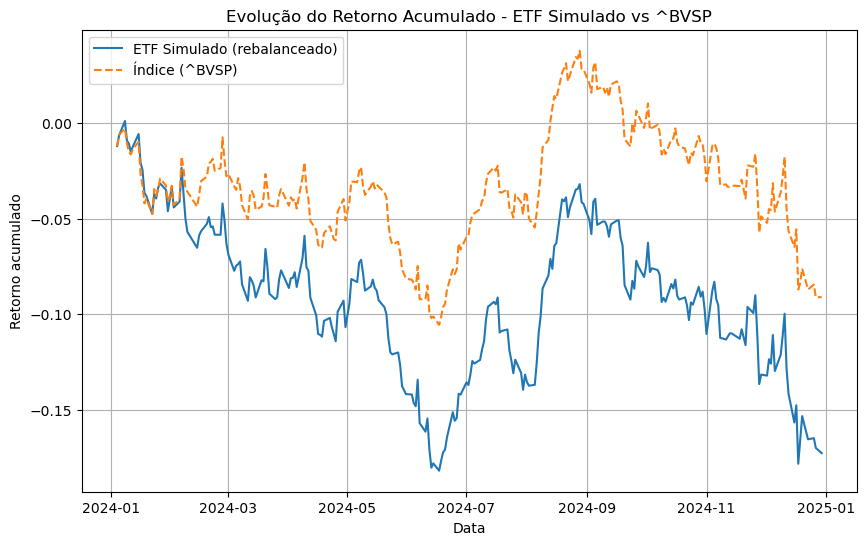

In [10]:
# --- Plot comparativo ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(portfolio_cumret_ibv.index, portfolio_cumret_ibv, label='ETF Simulado (rebalanceado)')
plt.plot(market_cumret_ibv.index, market_cumret_ibv, label='Índice (^BVSP)', linestyle='--')
plt.title(f"Evolução do Retorno Acumulado - ETF Simulado vs ^BVSP")
plt.xlabel("Data")
plt.ylabel("Retorno acumulado")
plt.legend()
plt.grid(True)
plt.show()